1. IMPORT CÁC THƯ VIỆN CẦN THIẾT

In [21]:
import os
import numpy as np
import cv2

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

2. TIỀN XỬ LÝ DỮ LIỆU:

In [22]:
# Load dữ liệu
def load_dataset_from_dir(data_dir, img_size=(64,64)):
    X, y = [], []
    classes = sorted(d for d in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, d)))
    label_map = {cls:i for i,cls in enumerate(classes)}

    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(('.jpg','.jpeg','.png')):
                path = os.path.join(cls_dir, fname)
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)                   
                img = img.astype(np.float16) / 255.0              
                X.append(img)
                y.append(cls)                                     

    X = np.array(X)                                         
    y = np.array(y)

    return X, y, label_map


# Đọc dữ liệu
dataset_path_train = '/kaggle/input/cus-hand-written/hand_written_digit/train'
dataset_path_test = '/kaggle/input/cus-hand-written/hand_written_digit/test'

X_train, y_train, label_map_train = load_dataset_from_dir(dataset_path_train, img_size=(64,64))
X_test, y_test, label_map_test = load_dataset_from_dir(dataset_path_test, img_size=(64,64))
print(f"Tổng số ảnh train: {len(X_train)}")
print(f"Tổng số ảnh test: {len(X_test)}")

Tổng số ảnh train: 3482
Tổng số ảnh test: 778


In [23]:
# Encode nhãn và chia dữ liệu train/test
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_test_num = le.fit_transform(y_test)
num_classes = len(le.classes_)

print(y_train_num)

[0 0 0 ... 9 9 9]


In [24]:
# Chia tập train-valid tỉ lệ 8-2
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train_num, test_size=0.2, random_state=42, stratify=y_train_num
)

print(f"Số ảnh TRAIN: {len(X_train_sub)}")
print(f"Số ảnh VALIDATION: {len(X_val)}")
print(f"Tổng số ảnh test: {len(X_test)}")

Số ảnh TRAIN: 2785
Số ảnh VALIDATION: 697
Tổng số ảnh test: 778


In [25]:
# One-hot encode Y
Y_train = to_categorical(y_train_sub, num_classes)
Y_val = to_categorical(y_val, num_classes)
Y_test = to_categorical(y_test, num_classes)

print(Y_train)
print(Y_val)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


3. XÂY DỰNG MÔ HÌNH

In [6]:
# Load mô hình VGG16 đã huấn luyện trước
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Đóng băng các lớp của VGG16 (chỉ fine-tune các lớp mới)
for layer in vgg16.layers:
    layer.trainable = False  # Các lớp của VGG16 sẽ không được huấn luyện lại

# Thêm các lớp mới cho bài toán phân loại
x = Flatten()(vgg16.output)  # Biến đầu ra thành một vector
x = Dense(256, activation='relu')(x)  # Lớp Fully Connected
x = Dropout(0.5)(x)  # Dropout để giảm overfitting
output = Dense(num_classes, activation='softmax')(x)  # Lớp phân loại

I0000 00:00:1750417140.372824      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750417140.373768      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Tạo mô hình mới từ VGG16 + các lớp phân loại mới
model = Model(inputs=vgg16.input, outputs=output)

# Tóm tắt mô hình
model.summary()

# Compile mô hình
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Callback cho việc dừng sớm nếu mô hình không cải thiện
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,241,802 (58.14 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

4. HUẤN LUYỆN MÔ HÌNH CNN

In [ ]:
# Huấn luyện mô hình
H = model.fit(
    X_train_sub, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=32,
    epochs=100,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/500


I0000 00:00:1750417145.975933      65 service.cc:148] XLA service 0x7c6b60012210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750417145.977588      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750417145.977618      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750417146.509465      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/44 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.1214 - loss: 2.5850

I0000 00:00:1750417151.709187      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 199ms/step - accuracy: 0.1925 - loss: 2.2692 - val_accuracy: 0.4892 - val_loss: 1.6892
Epoch 2/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.3849 - loss: 1.7234 - val_accuracy: 0.5466 - val_loss: 1.4731
Epoch 3/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.4994 - loss: 1.5202 - val_accuracy: 0.5524 - val_loss: 1.3545
Epoch 4/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5247 - loss: 1.3950 - val_accuracy: 0.6098 - val_loss: 1.2588
Epoch 5/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5866 - loss: 1.2823 - val_accuracy: 0.6341 - val_loss: 1.1944
Epoch 6/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5805 - loss: 1.2572 - val_accuracy: 0.6585 - val_loss: 1.1231
Epoch 7/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6277 - loss: 1.1628 - val_accuracy: 0.6399 - val_loss: 1.1014
Epoch 8/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6143 - loss: 1.1627 - val_accuracy: 0.6858 - val

In [9]:
# Lưu lại mô hình đã fine-tune
os.makedirs("/kaggle/working", exist_ok=True)
model.save("/kaggle/working/vgg16_finetuned_model.keras")

5. VISUALIZATION

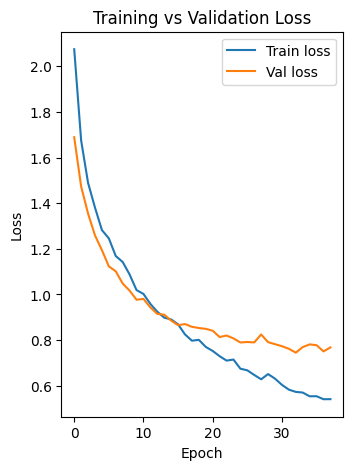

<function matplotlib.pyplot.show(close=None, block=None)>

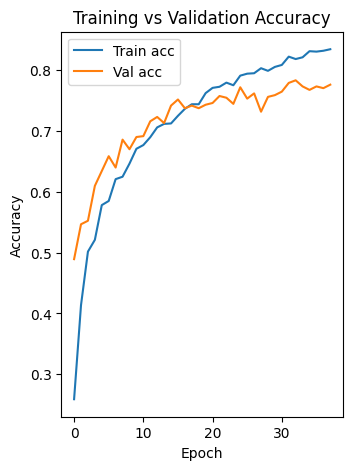

In [10]:
# 12. Vẽ đồ thị loss và accuracy của training & validation
# Loss
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 2)
plt.plot(H.history['loss'], label='Train loss')
plt.plot(H.history['val_loss'], label='Val loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
plt.plot(H.history['accuracy'], label='Train acc')
plt.plot(H.history['val_accuracy'], label='Val acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show


6. Đánh giá trên tập test

In [ ]:
from sklearn.metrics import classification_report

model = load_model('/kaggle/working/vgg16_finetuned_model.keras')

# Dự đoán nhãn trên tập test
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# In classification report
print("=== Classification Report trên tập TEST ===")
print(classification_report(y_test_num, y_test_pred, target_names=le.classes_))

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step
=== Classification Report trên tập TEST ===
              precision    recall  f1-score   support

           0       0.65      0.78      0.71        77
           1       0.55      0.82      0.66        77
           2       0.71      0.68      0.69        78
           3       0.61      0.74      0.67        80
           4       0.63      0.60      0.62        75
           5       0.69      0.62      0.65        76
           6       0.85      0.65      0.74        78
           7       0.80      0.66      0.72        79
           8       0.77      0.67      0.72        79
           9       0.77      0.65      0.70        79

    accuracy                           0.69       778
   macro avg       0.70      0.69      0.69       778
weighted avg       0.70      0.69      0.69       778



7. Dự đoán trên tập Predict

In [ ]:
import os
import cv2
import numpy as np

model = load_model('/kaggle/working/vgg16_finetuned_model.keras')

# Hàm dự đoán và lưu kết quả
def predict_and_save_results(model, data_dir, img_size=(64,64)):
    X, filenames = [], []
    
    # Kiểm tra lại img_size có đúng định dạng không
    if not isinstance(img_size, tuple) or len(img_size) != 2:
        raise ValueError(f"img_size phải là một tuple có 2 phần tử. Hiện tại là {img_size}")
    
    # Duyệt qua tất cả các file trong thư mục dữ liệu
    for fname in os.listdir(data_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):  # Lọc các ảnh
            path = os.path.join(data_dir, fname)
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Đổi sang RGB
            
            # Resize hình ảnh về kích thước 64x64
            img = cv2.resize(img, img_size)  # Resize ảnh
            img = img.astype(np.float16) / 255.0  # Chuẩn hóa ảnh
            X.append(img)
            filenames.append(fname)
    
    # Chuyển X thành mảng numpy
    X = np.array(X)
    
    # Dự đoán nhãn
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)  # Lấy nhãn có xác suất cao nhất

    # Lưu kết quả vào file CSV với định dạng tên file và nhãn
    result_file = '/kaggle/working/predictions.csv'
    with open(result_file, 'w') as f:
        for fname, predicted_class in zip(filenames, predicted_classes):
            # Đảm bảo giữ nguyên tên file đầy đủ (bao gồm phần mở rộng)
            f.write(f"{fname},{predicted_class}\n")
    
    print(f"Results saved to {result_file}")

# Dự đoán cho bộ test
dataset_path_test = '/kaggle/input/hand-written'
predict_and_save_results(model, dataset_path_test)

305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step
Results saved to /kaggle/working/predictions.csv
